In [7]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [9]:
import numpy as np
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, roc_curve, auc
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from xgboost import plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [11]:
transactions = pd.read_csv('C:/Users/User/Desktop/CRM/Retail_Data_Transactions.csv', parse_dates=['trans_date'])
transactions.head()

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78


In [12]:
response = pd.read_csv('C:/Users/User/Desktop/CRM/Retail_Data_Response.csv')
response.head()

,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1


In [13]:
print(transactions['trans_date'].min())
print(transactions['trans_date'].max())

2011-05-16 00:00:00
2015-03-16 00:00:00


# Data Preparation

In [14]:
## since the last date of the data is 16 March 2015, the campaign date is assumed to be 17 March 2015
## RFM model will be used to predict campaign response. Recency is calculated

campaigndate = dt.datetime(2015,3,17)
transactions['recent']= campaigndate - transactions['trans_date']
transactions['recent'].astype('timedelta64[D]')
transactions['recent']=transactions['recent'] / np.timedelta64(1, 'D')
transactions.head()

,customer_id,trans_date,tran_amount,recent
0,CS5295,2013-02-11,35,764.0
1,CS4768,2015-03-15,39,2.0
2,CS2122,2013-02-26,52,749.0
3,CS1217,2011-11-16,99,1217.0
4,CS1850,2013-11-20,78,482.0


In [16]:
## create data set with RFM variables

rfm = transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum()}) # Monetary Value

rfm.rename(columns={'recent': 'recency', 
                         'customer_id': 'frequency', 
                         'tran_amount': 'monetary_value'}, inplace=True)
rfm = rfm.reset_index()
rfm.head(10)

,customer_id,recency,frequency,monetary_value
0,CS1112,62.0,15,1012
1,CS1113,36.0,20,1490
2,CS1114,33.0,19,1432
3,CS1115,12.0,22,1659
4,CS1116,204.0,13,857
5,CS1117,258.0,17,1185
6,CS1118,3.0,15,1011
7,CS1119,12.0,15,1158
8,CS1120,11.0,24,1677
9,CS1121,42.0,26,1524


In [18]:
#Calculating response rate
response_rate = response.groupby('response').agg({'customer_id': lambda x: len(x)}).reset_index()
response_rate.head()

,response,customer_id
0,0,6237
1,1,647


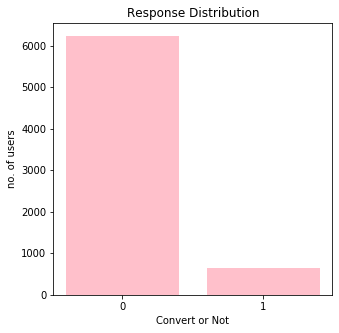

In [19]:
## data is imbalanced
plt.figure(figsize=(5,5))
x=range(2)
plt.bar(x,response_rate['customer_id'] , color = 'Pink')
plt.xticks(response_rate.index)
plt.title('Response Distribution')
plt.xlabel('Convert or Not')
plt.ylabel('no. of users')
plt.show()

In [21]:
## merging two data sets
df_modeling = pd.merge(response,rfm)
df_modeling.head()

,customer_id,response,recency,frequency,monetary_value
0,CS1112,0,62.0,15,1012
1,CS1113,0,36.0,20,1490
2,CS1114,1,33.0,19,1432
3,CS1115,1,12.0,22,1659
4,CS1116,1,204.0,13,857


# Creating train and test dataset

In [22]:
## spliting dataframe into X and y
X = df_modeling.drop(columns=['response','customer_id'])
y = df_modeling['response']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (4130, 3)
Number transactions X_test dataset:  (2754, 3)
Number transactions y_train dataset:  (4130,)
Number transactions y_test dataset:  (2754,)


Text(0.5, 1.0, 'Imbalanced Data')

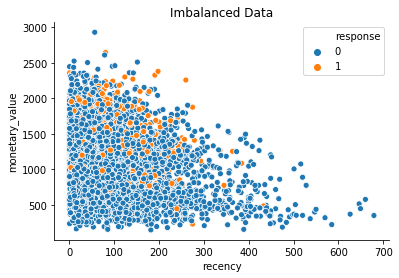

In [23]:
sns.scatterplot(data=df_modeling, x='recency', y='monetary_value', hue='response')
sns.despine()
plt.title("Imbalanced Data")

# Fixing imbalanced with Undersampling

Text(0.5, 1.0, 'Undersampled Data')

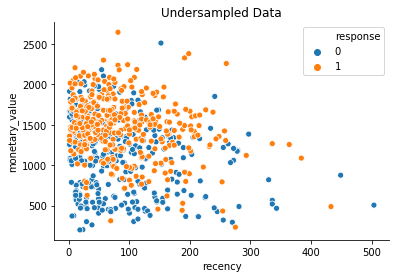

In [32]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0)
rus.fit(X_train, y_train)
X_undersampled, y_undersampled = rus.fit_resample(X_train, y_train)
df_undersampled = pd.concat([pd.DataFrame(data=X_undersampled),pd.DataFrame(data=y_undersampled)], axis=1, sort=False)
df_undersampled.columns= ['recency', 'frequency', 'monetary_value', 'response']

sns.scatterplot(data=df_undersampled, x='recency', y='monetary_value', hue='response')
sns.despine()
plt.title("Undersampled Data")

# Fixing imbalanced with Oversampling

Text(0.5, 1.0, 'Oversampled Data')

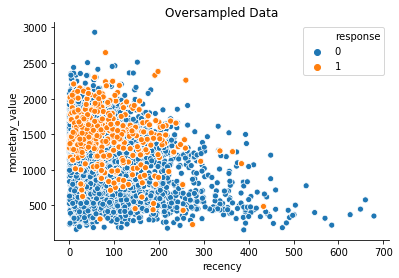

In [36]:
ros = RandomOverSampler(random_state=0)
ros.fit(X_train, y_train)
X_oversampled, y_oversampled = ros.fit_resample(X_train, y_train)
df_oversampled = pd.concat([pd.DataFrame(data=X_oversampled),pd.DataFrame(data=y_oversampled)], axis=1, sort=False )
df_oversampled.columns= ['recency', 'frequency', 'monetary_value', 'response']

sns.scatterplot(data=df_oversampled, x='recency', y='monetary_value', hue='response' )
sns.despine()
plt.title("Oversampled Data")

# Fixing imbalanced with SMOTE

Text(0.5, 1.0, 'SMOTE Data')

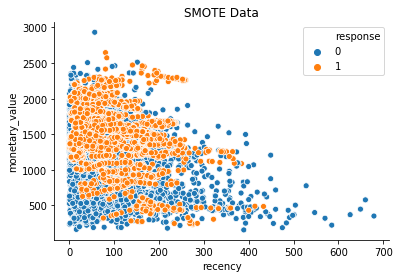

In [37]:
sm = SMOTE(random_state=0)
sm.fit(X_train, y_train)
X_SMOTE, y_SMOTE = sm.fit_resample(X_train, y_train)
df_SMOTE = pd.concat([pd.DataFrame(data=X_SMOTE),pd.DataFrame(data=y_SMOTE)], axis=1, sort=False)
df_SMOTE.columns= ['recency', 'frequency', 'monetary_value', 'response']

sns.scatterplot(data=df_SMOTE, x='recency', y='monetary_value', hue='response')
sns.despine()
plt.title("SMOTE Data")

# Logistic Regression Model

In [39]:
print('logistic regression model - undersampled')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')

predicted_y = []
expected_y = []

logreg_model_under = logreg.fit(X_undersampled, y_undersampled)
predictions = logreg_model_under.predict(X_undersampled)
predicted_y.extend(predictions)
expected_y.extend(y_undersampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_under.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test)

logistic regression model - undersampled
training set
              precision    recall  f1-score   support

           0       0.65      0.58      0.61       368
           1       0.62      0.69      0.65       368

    accuracy                           0.63       736
   macro avg       0.63      0.63      0.63       736
weighted avg       0.63      0.63      0.63       736

test set
              precision    recall  f1-score   support

           0       0.95      0.62      0.75      2475
           1       0.18      0.72      0.28       279

    accuracy                           0.63      2754
   macro avg       0.56      0.67      0.52      2754
weighted avg       0.87      0.63      0.70      2754



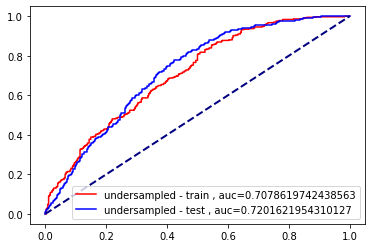

[[0.00373001 0.02087586 0.0015535 ]] [-2.75573748]


In [42]:
y_score_train = logreg_model_under.decision_function(X_undersampled)
fpr_train, tpr_train, _ = roc_curve(y_undersampled,  y_score_train)
auc_train = roc_auc_score(y_undersampled, y_score_train)
plt.plot(fpr_train,tpr_train, color='red', label='undersampled - train , auc='+str(auc_train))

y_score_test = logreg_model_under.decision_function(X_test)
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test)
auc_test = roc_auc_score(y_test, y_score_test)
plt.plot(fpr_test,tpr_test, color='Blue', label='undersampled - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()
print(logreg_model_under.coef_, logreg_model_under.intercept_)

In [43]:
print('logistic regression model - oversampled')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_over = logreg.fit(X_oversampled, y_oversampled)
predictions = logreg_model_over.predict(X_oversampled)
predicted_y.extend(predictions)
expected_y.extend(y_oversampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_over.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test)

logistic regression model - oversampled
training set
              precision    recall  f1-score   support

           0       0.67      0.62      0.64      3762
           1       0.64      0.69      0.67      3762

    accuracy                           0.65      7524
   macro avg       0.65      0.65      0.65      7524
weighted avg       0.65      0.65      0.65      7524

test set
              precision    recall  f1-score   support

           0       0.95      0.62      0.75      2475
           1       0.17      0.71      0.28       279

    accuracy                           0.63      2754
   macro avg       0.56      0.66      0.51      2754
weighted avg       0.87      0.63      0.70      2754



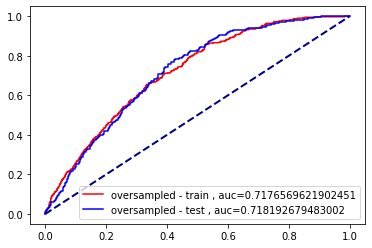

[[ 0.0042164  -0.00489072  0.00209969]] [-2.75573748]


In [44]:
y_score_train = logreg_model_over.decision_function(X_oversampled)
fpr_train, tpr_train, _ = roc_curve(y_oversampled,  y_score_train)
auc_train = roc_auc_score(y_oversampled, y_score_train)
plt.plot(fpr_train,tpr_train, color='red', label='oversampled - train , auc='+str(auc_train))

y_score_test = logreg_model_over.decision_function(X_test)
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test)
auc_test = roc_auc_score(y_test, y_score_test)
plt.plot(fpr_test,tpr_test, color='Blue', label='oversampled - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()
print(logreg_model_over.coef_, logreg_model_under.intercept_)

In [45]:
print('logistic regression model - SMOTE')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_SMOTE = logreg.fit(X_SMOTE, y_SMOTE)
predictions = logreg_model_SMOTE.predict(X_SMOTE)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_SMOTE.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test)

logistic regression model - SMOTE
training set
              precision    recall  f1-score   support

           0       0.69      0.60      0.64      3762
           1       0.64      0.73      0.68      3762

    accuracy                           0.66      7524
   macro avg       0.67      0.66      0.66      7524
weighted avg       0.67      0.66      0.66      7524

test set
              precision    recall  f1-score   support

           0       0.95      0.59      0.72      2475
           1       0.16      0.71      0.26       279

    accuracy                           0.60      2754
   macro avg       0.55      0.65      0.49      2754
weighted avg       0.87      0.60      0.68      2754



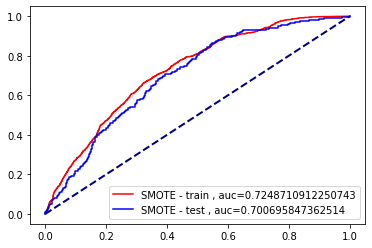

In [46]:
y_score_train = logreg_model_SMOTE.decision_function(X_SMOTE)
fpr_train, tpr_train, _ = roc_curve(y_SMOTE,  y_score_train)
auc_train = roc_auc_score(y_SMOTE, y_score_train)
plt.plot(fpr_train,tpr_train, color='red', label='SMOTE - train , auc='+str(auc_train))

y_score_test = logreg_model_SMOTE.decision_function(X_test)
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test)
auc_test = roc_auc_score(y_test, y_score_test)
plt.plot(fpr_test,tpr_test, color='Blue', label='SMOTE - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

# Improve Model

In [50]:
#Add  feature
campaigndate = dt.datetime(2015,3,17)
transactions['first_transaction']= campaigndate - transactions['trans_date']
transactions['first_transaction'].astype('timedelta64[D]')
transactions['first_transaction']=transactions['first_transaction'] / np.timedelta64(1, 'D')
transactions['age_of_T']= campaigndate - transactions['trans_date']
transactions['age_of_T'].astype('timedelta64[D]')
transactions['age_of_T']=transactions['age_of_T'] / np.timedelta64(1, 'D')
transactions.head()

,customer_id,trans_date,tran_amount,recent,first_transaction,age_of_T
0,CS5295,2013-02-11,35,764.0,764.0,764.0
1,CS4768,2015-03-15,39,2.0,2.0,2.0
2,CS2122,2013-02-26,52,749.0,749.0,749.0
3,CS1217,2011-11-16,99,1217.0,1217.0,1217.0
4,CS1850,2013-11-20,78,482.0,482.0,482.0


In [52]:
# RFM variables

rfm = transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum(),                # Monetary Value
                                                     'first_transaction': lambda x:x.max(),
                                                     'age_of_T': lambda x:x.max()-x.min()}) 
rfm.rename(columns={'recent': 'recency', 
                         'customer_id': 'frequency', 
                         'tran_amount': 'monetary_value',
                         'first_transaction': 'first_transaction',
                         'age_of_T': 'age_of_T'
                       }, inplace=True)

In [53]:
rfm['rfm'] = rfm['recency'] * rfm['frequency'] * rfm['monetary_value']
rfm = rfm.reset_index()
rfm.head()

,customer_id,recency,frequency,monetary_value,first_transaction,age_of_T,rfm
0,CS1112,62.0,15,1012,1371.0,1309.0,941160.0
1,CS1113,36.0,20,1490,1390.0,1354.0,1072800.0
2,CS1114,33.0,19,1432,1342.0,1309.0,897864.0
3,CS1115,12.0,22,1659,1315.0,1303.0,437976.0
4,CS1116,204.0,13,857,1359.0,1155.0,2272764.0


In [56]:
modeling = pd.merge(response,rfm)
modeling.head()

,customer_id,response,recency,frequency,monetary_value,first_transaction,age_of_T,rfm
0,CS1112,0,62.0,15,1012,1371.0,1309.0,941160.0
1,CS1113,0,36.0,20,1490,1390.0,1354.0,1072800.0
2,CS1114,1,33.0,19,1432,1342.0,1309.0,897864.0
3,CS1115,1,12.0,22,1659,1315.0,1303.0,437976.0
4,CS1116,1,204.0,13,857,1359.0,1155.0,2272764.0


In [57]:
## spliting dataframe X and y

X = modeling.drop(columns=['first_transaction','age_of_T','rfm','response','customer_id'])
# X = df_modeling[['age_of_T','rfm']]
y = df_modeling['response']

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (4818, 3)
Number transactions y_train dataset:  (4818,)
Number transactions X_test dataset:  (2066, 3)
Number transactions y_test dataset:  (2066,)


In [60]:
sm = SMOTE(random_state=0)
sm.fit(X_train, y_train)
X_SMOTE, y_SMOTE = sm.fit_resample(X_train, y_train)
df_SMOTE_imp = pd.concat([pd.DataFrame(data=X_SMOTE),pd.DataFrame(data=y_SMOTE)], axis=1, sort=False)
df_SMOTE_imp.columns= ['recency', 'frequency', 'monetary_value', 'response']
# df_SMOTE_imp.columns= ['age_of_T','rfm', 'response']

In [61]:
df_SMOTE_imp['response'].unique()
df_SMOTE_imp.describe()

,recency,frequency,monetary_value,response
count,8778.000000,8778.000000,8778.000000,8778.000000
mean,82.329037,19.370016,1311.387218,0.500000
std,75.408961,4.904165,439.384546,0.500028
min,1.000000,4.000000,157.000000,0.000000
25%,27.395891,16.000000,1048.000000,0.000000
50%,62.762745,20.000000,1376.000000,0.500000
75%,115.295107,23.000000,1607.000000,1.000000
max,679.000000,39.000000,2933.000000,1.000000


Text(0.5, 1.0, 'SMOTE Data')

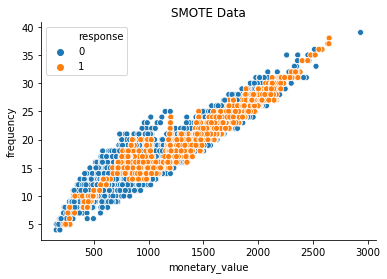

In [62]:
sns.scatterplot(data=df_SMOTE_imp, x='monetary_value', y='frequency', hue='response')
sns.despine()
plt.title("SMOTE Data")

Text(0.5, 1.0, 'SMOTE Data')

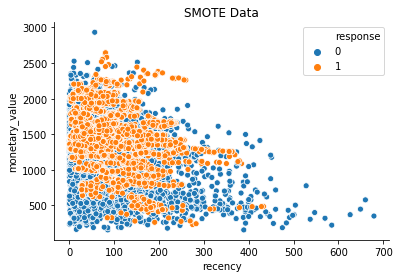

In [63]:
sns.scatterplot(data=df_SMOTE_imp, x='recency', y='monetary_value', hue='response')
sns.despine()
plt.title("SMOTE Data")

Text(0.5, 1.0, 'SMOTE Data')

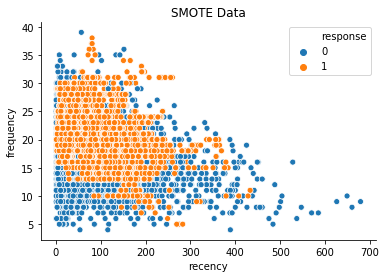

In [64]:
sns.scatterplot(data=df_SMOTE_imp, x='recency', y='frequency', hue='response')
sns.despine()
plt.title("SMOTE Data")

In [65]:
#Check Imbalance
df_SMOTE_imp.response.value_counts()

0    4389
1    4389
Name: response, dtype: int64

In [66]:
import sklearn
sklearn.__version__

'0.24.2'

In [67]:
from sklearn.model_selection import KFold

In [72]:
#K-Fold Cross validation
kf = KFold(n_splits=12,shuffle=True,random_state=101)
for train_index, test_index in kf.split(X):
  X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
  y_train, y_test = y[train_index], y[test_index]
  print('Train Shape X: {} Y : {}'.format(X_train.shape,y_train.shape))
  print('Test Shape X: {} Y : {}'.format(X_test.shape,y_test.shape))
  
#Fix Imbalance with SMOTE
  sm = SMOTE(random_state=0)
  sm.fit(X_train, y_train)
  X_SMOTE, y_SMOTE = sm.fit_resample(X_train, y_train)

Train Shape X: (6310, 3) Y : (6310,)
Test Shape X: (574, 3) Y : (574,)
Train Shape X: (6310, 3) Y : (6310,)
Test Shape X: (574, 3) Y : (574,)
Train Shape X: (6310, 3) Y : (6310,)
Test Shape X: (574, 3) Y : (574,)
Train Shape X: (6310, 3) Y : (6310,)
Test Shape X: (574, 3) Y : (574,)
Train Shape X: (6310, 3) Y : (6310,)
Test Shape X: (574, 3) Y : (574,)
Train Shape X: (6310, 3) Y : (6310,)
Test Shape X: (574, 3) Y : (574,)
Train Shape X: (6310, 3) Y : (6310,)
Test Shape X: (574, 3) Y : (574,)
Train Shape X: (6310, 3) Y : (6310,)
Test Shape X: (574, 3) Y : (574,)
Train Shape X: (6311, 3) Y : (6311,)
Test Shape X: (573, 3) Y : (573,)
Train Shape X: (6311, 3) Y : (6311,)
Test Shape X: (573, 3) Y : (573,)
Train Shape X: (6311, 3) Y : (6311,)
Test Shape X: (573, 3) Y : (573,)
Train Shape X: (6311, 3) Y : (6311,)
Test Shape X: (573, 3) Y : (573,)


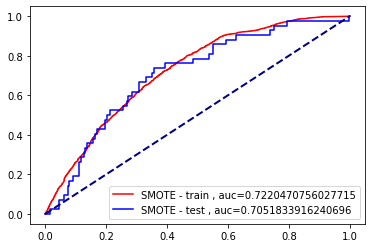

In [73]:
y_score_train = logreg_model_SMOTE.decision_function(X_SMOTE)
fpr_train, tpr_train, _ = roc_curve(y_SMOTE,  y_score_train)
auc_train = roc_auc_score(y_SMOTE, y_score_train)
plt.plot(fpr_train,tpr_train, color='red', label='SMOTE - train , auc='+str(auc_train))

y_score_test = logreg_model_SMOTE.decision_function(X_test)
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test)
auc_test = roc_auc_score(y_test, y_score_test)
plt.plot(fpr_test,tpr_test, color='Blue', label='SMOTE - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()